In [1]:
# help(swiss)
head(swiss)

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17.0,15,12,9.96,22.2
Delemont,83.1,45.1,6,9,84.84,22.2
Franches-Mnt,92.5,39.7,5,5,93.40,20.2
Moutier,85.8,36.5,12,7,33.77,20.3
Neuveville,76.9,43.5,17,15,5.16,20.6
Porrentruy,76.1,35.3,9,7,90.57,26.6


Swiss is a data frame with 47 observations on 6 variables (each of which is in percent) which shows the standardised fertility measure and socio-economic indicators for each of 47 French-speaking provinces of Switzerland at about 1888. 

# Single decision tree 

In [2]:
set.seed(20)
training.rows = sample(1:nrow(swiss), 0.5*nrow(swiss))
training.rows

[1] 38 43  2 34 29 30 41  3 14  8  9 21 17  6 20 22  5 37 46 45 25 32 31

In [3]:
train = swiss[training.rows, ]
head(train)

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Sion,79.3,63.1,13,13,96.83,18.1
Val de Ruz,77.6,37.6,15,7,4.97,20.0
Delemont,83.1,45.1,6,9,84.84,22.2
Martigwy,70.5,78.2,12,6,98.96,19.4
Vevey,58.3,26.8,25,19,18.46,20.9
Yverdon,65.4,49.5,15,8,6.10,22.5


In [4]:
# install.packages("tree")
library(tree)

Warning message:
"package 'tree' was built under R version 3.6.3"

In [5]:
s_tree = tree(Fertility ~ ., data = train)
s_tree

node), split, n, deviance, yval
      * denotes terminal node

1) root 23 4117.0 71.85  
  2) Catholic < 67.635 13 1831.0 64.56  
    4) Catholic < 5.665 8  183.7 70.40 *
    5) Catholic > 5.665 5  938.2 55.22 *
  3) Catholic > 67.635 10  697.2 81.33  
    6) Infant.Mortality < 20 5  339.5 77.36 *
    7) Infant.Mortality > 20 5  200.1 85.30 *

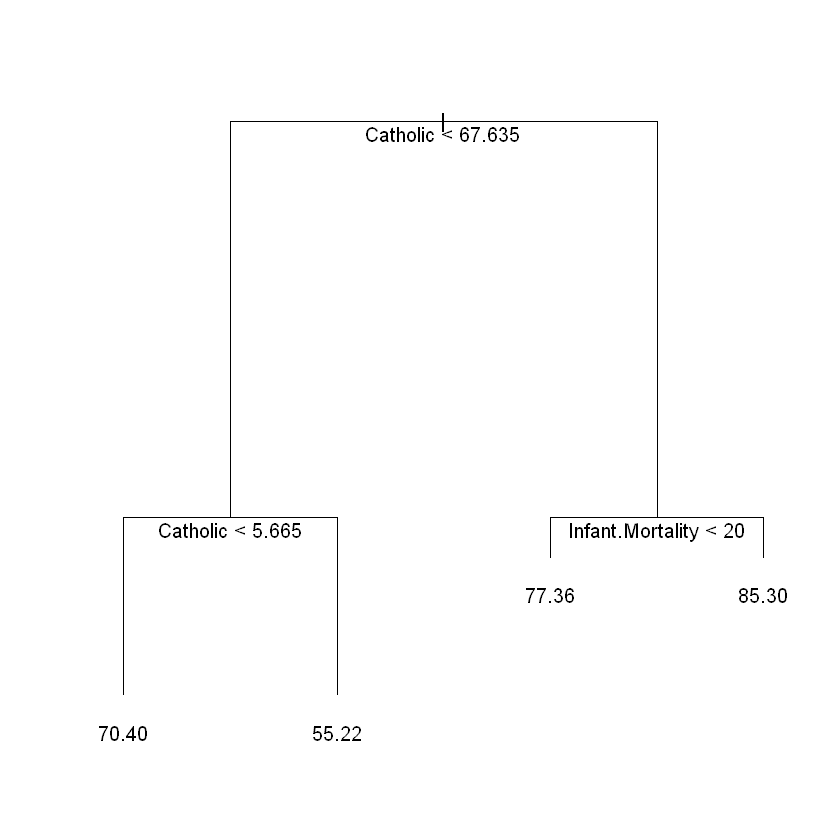

In [6]:
plot(s_tree)
text(s_tree, pos = 1, offset = 1)

In [7]:
swiss["Courtelary", ]

,Fertility,Agriculture,Examination,Education,Catholic,Infant.Mortality
Courtelary,80.2,17,15,12,9.96,22.2


In [8]:
predict(s_tree, swiss["Courtelary", ])

Courtelary 
     55.22

In [9]:
test = swiss[-training.rows, ]
y_tree = predict(s_tree, test)

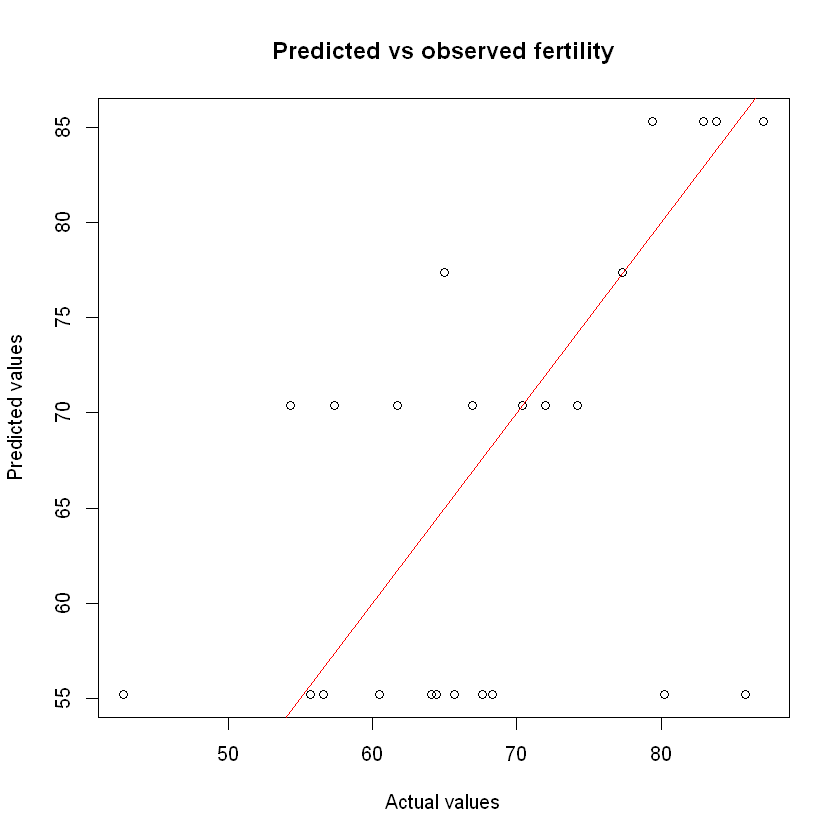

In [10]:
plot(test$Fertility, y_tree, main = "Predicted vs observed fertility",
    ylab = "Predicted values", xlab = "Actual values")
abline(0, 1, col = "red")

# Bootstrapped sample

In [11]:
# Get bootstrapped sampe 
set.seed(8499)
bag.rows = sample(1:nrow(train), replace = TRUE)
bag = train[bag.rows, ]

# Fit decision tree
s_bag = tree(Fertility ~ ., data = bag)

# Predict 
predict(s_bag, test["Courtelary", ])

Courtelary 
     75.68

The predicted values of 55.22 and 75.68 are quite different. This reflects the fact that a decision tree is typically a high variance model. In other words, using a slightly different data set to train the model can lead to a very different decision tree and hence predictions. 

One way to approach this issue is with the idea of bagged decision trees where many trees are constructed and the predictions averaged to obtain an overall single prediction.

The true value of Fertility for Courtelary is 80.2, so the second tree's prediction of 75.68 is much closer. However, we have only directly compared the prediction for one province. Even though the second tree's prediction is closer for Courtelary, we don't know for certain if it performs better overall. 

# Random forest

In [12]:
trees = 1000
preds = matrix(NA, nrow = nrow(test), ncol = trees)

In [13]:
set.seed(8499)
for(i in 1:trees) {
    bag.rows = sample(1:nrow(train), replace = TRUE)
    bag = train[bag.rows, ]
    s_bag = tree(Fertility ~ ., data = bag)
    preds[, i] = predict(s_bag, test)
}
y_bag = rowMeans(preds)

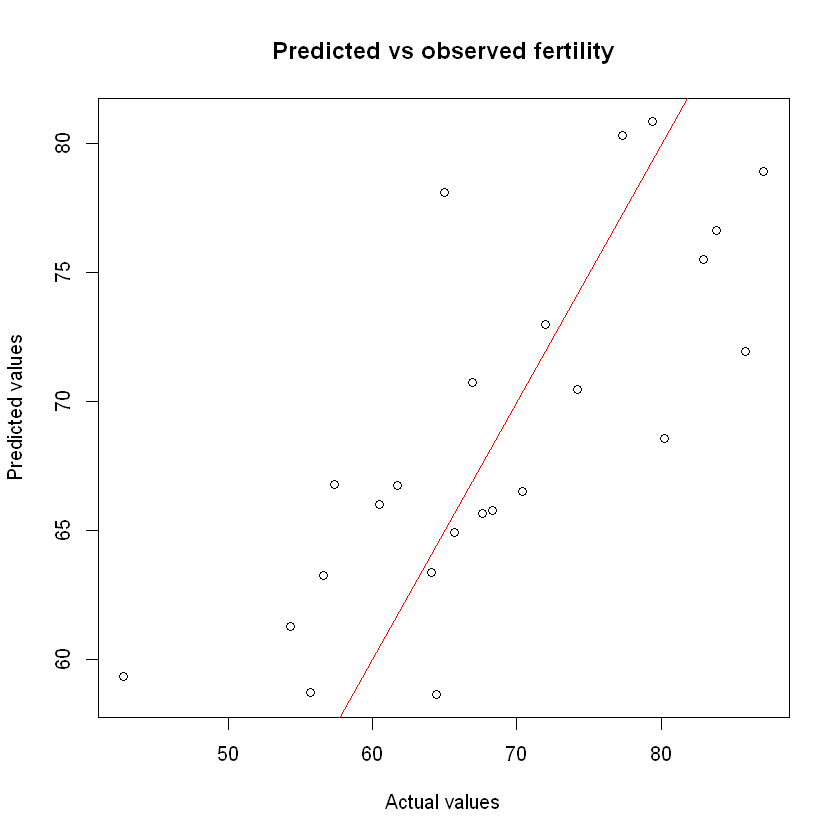

In [14]:
plot(test$Fertility, y_bag, main = "Predicted vs observed fertility",
    ylab = "Predicted values", xlab = "Actual values")
abline(0, 1, col = "red")

The previous graph shows that the single decision tree constructed with the training data performs poorly when predicting the test data. The points are quite far from the reference line and for many of the external nodes the points don't seem broadly scattered around the line. So, the predicted value in these external nodes even appears quite far from the average value of the test data points falling in those nodes. 

The bagged decision tree approach, on the other hand, appears to perform much better. The points are much more tightly spread around the reference line. However, some points still appear to have large differences between actual and predicted.

In [15]:
round(mean((test$Fertility - y_tree)^2), 2)
round(mean((test$Fertility - y_bag)^2), 2)

[1] 128.03

[1] 53.85

The MSE for the decision tree is 128.03 and the MSE for the bagged approach is 53.85.

As expected, the MSE for the bagged predictions is much lower, indicated that the bagged predictions are much closer to the true values on average. This aligns with our comments about the graphs, the bagged predictions show much better alignment with the true values.